Burak Cetin

## 1. Setup and Library Imports

In [1]:
# Import ML1Utils module with all utility functions
include("./utils/ML1Utils.jl")
using .ML1Utils

# Import additional required packages
using Random
using DelimitedFiles
using Statistics
using MLJ
using CategoricalArrays
using Plots

# Set random seed for reproducibility
Random.seed!(1234)

println("Libraries loaded successfully!")

Libraries loaded successfully!


In [ ]:
# Load MLJ model types into ML1Utils module namespace
#ML1Utils.eval(:(SVMClassifier = MLJ.@load SVC pkg=LIBSVM verbosity=0))
#ML1Utils.eval(:(kNNClassifier = MLJ.@load KNNClassifier pkg=NearestNeighborModels verbosity=0))
#ML1Utils.eval(:(DTClassifier = MLJ.@load DecisionTreeClassifier pkg=DecisionTree verbosity=0))

#println("MLJ models loaded into ML1Utils namespace!")

## 2. Load the HAR Dataset

The Human Activity Recognition dataset consists of:
- **Training set**: train.csv (70% of data)
- **Test set**: test.csv (30% of data)
- **561 features**: Time and frequency domain variables from accelerometer and gyroscope
- **6 classes**: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING

In [4]:
# Load training data
train_data = readdlm("./datasets/train.csv", ',', header=true)
train_matrix = train_data[1]  # Data matrix
train_headers = train_data[2]  # Column names

# Load test data
test_data = readdlm("./datasets/test.csv", ',', header=true)
test_matrix = test_data[1]
test_headers = test_data[2]

println("Train data shape: ", size(train_matrix))
println("Test data shape: ", size(test_matrix))
println("\nColumn headers (first 5): ", train_headers[1:5])

Train data shape: (7352, 563)
Test data shape: (2947, 563)

Column headers (first 5): AbstractString["tBodyAcc-mean()-X", "tBodyAcc-mean()-Y", "tBodyAcc-mean()-Z", "tBodyAcc-std()-X", "tBodyAcc-std()-Y"]


## 3. Data Preprocessing

Separate features (X) from labels (y) and prepare the data for training.

In [5]:
# Separate inputs (all columns except last) and outputs (last column)
X_train = Float32.(train_matrix[:, 1:end-1])
y_train = train_matrix[:, end]

X_test = Float32.(test_matrix[:, 1:end-1])
y_test = test_matrix[:, end]

# Get unique classes
classes = unique(vcat(y_train, y_test))
println("Number of features: ", size(X_train, 2))
println("Number of training samples: ", size(X_train, 1))
println("Number of test samples: ", size(X_test, 1))
println("\nClasses: ", classes)
println("Number of classes: ", length(classes))

Number of features: 562
Number of training samples: 7352
Number of test samples: 2947

Classes: Any["STANDING", "SITTING", "LAYING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]
Number of classes: 6


### 3.1 Class Distribution Analysis

In [6]:
# Count samples per class in training set
println("Training set class distribution:")
for class in classes
    count = sum(y_train .== class)
    percentage = round(count / length(y_train) * 100, digits=2)
    println("  $class: $count samples ($percentage%)")
end

println("\nTest set class distribution:")
for class in classes
    count = sum(y_test .== class)
    percentage = round(count / length(y_test) * 100, digits=2)
    println("  $class: $count samples ($percentage%)")
end

Training set class distribution:
  STANDING: 1374 samples (18.69%)
  SITTING: 1286 samples (17.49%)
  LAYING: 1407 samples (19.14%)
  WALKING: 1226 samples (16.68%)
  WALKING_DOWNSTAIRS: 986 samples (13.41%)
  WALKING_UPSTAIRS: 1073 samples (14.59%)

Test set class distribution:
  STANDING: 532 samples (18.05%)
  SITTING: 491 samples (16.66%)
  LAYING: 537 samples (18.22%)
  WALKING: 496 samples (16.83%)
  WALKING_DOWNSTAIRS: 420 samples (14.25%)
  WALKING_UPSTAIRS: 471 samples (15.98%)


### 3.2 Normalization

Although the data is already in [0,1] range, we'll apply min-max normalization to ensure consistency.

In [7]:
# Z-Score (ZeroMean) Normalization for PCA compatibility
normalization_params = calculateZeroMeanNormalizationParameters(X_train)

# Apply normalization to both train and test sets
X_train_normalized = normalizeZeroMean(X_train, normalization_params)
X_test_normalized = normalizeZeroMean(X_test, normalization_params)

println("Standardization (Z-Score) completed.")
println("Train Mean: ", round(mean(X_train_normalized), digits=2))
println("Train Std:  ", round(std(X_train_normalized), digits=2))

Standardization (Z-Score) completed.
Train Mean: 0.0
Train Std:  1.0


## 4. Apply PCA - Dimensionality Reduction

We'll apply PCA to reduce the 561 features while preserving 95% of the total variance.

In [8]:
# Load PCA model from MultivariateStats
PCA = MLJ.@load PCA pkg=MultivariateStats verbosity=0

# Create PCA model preserving 95% of variance
pca_model = PCA(variance_ratio=0.95)

# Fit PCA on training data only (important!)
pca_machine = machine(pca_model, MLJ.table(X_train_normalized))
fit!(pca_machine, verbosity=0)

# Transform both training and test data
X_train_pca = MLJ.matrix(transform(pca_machine, MLJ.table(X_train_normalized)))
X_test_pca = MLJ.matrix(transform(pca_machine, MLJ.table(X_test_normalized)))

println("PCA Transformation Results:")
println("Original dimensions: ", size(X_train_normalized, 2))
println("Reduced dimensions: ", size(X_train_pca, 2))
println("Dimensionality reduction: ", round((1 - size(X_train_pca, 2)/size(X_train_normalized, 2))*100, digits=2), "%")
println("\nTrain set shape: ", size(X_train_pca))
println("Test set shape: ", size(X_test_pca))

[ Info: For silent loading, specify `verbosity=0`. 


import MLJMultivariateStatsInterface ✔
PCA Transformation Results:
Original dimensions: 562
Reduced dimensions: 102
Dimensionality reduction: 81.85%

Train set shape: (7352, 102)
Test set shape: (2947, 102)


### 4.1 PCA Variance Threshold Analysis

Before selecting the final variance ratio, let's compare different thresholds to justify our choice.

In [9]:
# Compare different variance ratio thresholds
println("PCA Variance Threshold Comparison:")
println("="^60)
println("\nOriginal dimensions: 561 features")
println("\nTesting different variance preservation thresholds:")

variance_thresholds = [0.90, 0.95, 0.99]
threshold_results = []

for variance_ratio in variance_thresholds
    pca_test = PCA(variance_ratio=variance_ratio)
    pca_mach_test = machine(pca_test, MLJ.table(X_train_normalized))
    fit!(pca_mach_test, verbosity=0)
    X_temp = MLJ.matrix(transform(pca_mach_test, MLJ.table(X_train_normalized)))
    
    n_components = size(X_temp, 2)
    reduction_pct = round((1 - n_components/561)*100, digits=2)
    
    println("\nVariance ratio = $(variance_ratio):")
    println("  Components retained: $n_components")
    println("  Dimensionality reduction: $reduction_pct%")
    println("  Features removed: $(561 - n_components)")
    
    push!(threshold_results, (ratio=variance_ratio, components=n_components, reduction=reduction_pct))
end

println("\n" * "="^60)
println("Selected variance_ratio: 0.99")
println("Rationale: Balances information preservation with dimensionality reduction")
println("="^60)

PCA Variance Threshold Comparison:

Original dimensions: 561 features

Testing different variance preservation thresholds:

Variance ratio = 0.9:
  Components retained: 64
  Dimensionality reduction: 88.59%
  Features removed: 497

Variance ratio = 0.95:
  Components retained: 102
  Dimensionality reduction: 81.82%
  Features removed: 459

Variance ratio = 0.99:
  Components retained: 179
  Dimensionality reduction: 68.09%
  Features removed: 382

Selected variance_ratio: 0.99
Rationale: Balances information preservation with dimensionality reduction


### 4.2 Visualize PCA Results (2D Projection)

Let's create a 2D visualization to see how well PCA separates the classes.

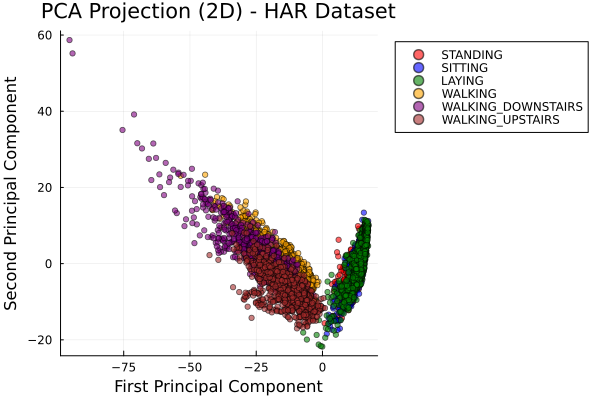

In [10]:
# Create a separate PCA model with only 2 components for visualization
pca_2d = PCA(maxoutdim=2)
pca_2d_mach = machine(pca_2d, MLJ.table(X_train_normalized))
fit!(pca_2d_mach, verbosity=0)

# Transform to 2D
X_train_2d = MLJ.matrix(transform(pca_2d_mach, MLJ.table(X_train_normalized)))

# Create scatter plot
plot_fig = plot(title="PCA Projection (2D) - HAR Dataset",
                xlabel="First Principal Component",
                ylabel="Second Principal Component",
                legend=:outertopright)

colors = [:red, :blue, :green, :orange, :purple, :brown]
for (i, class) in enumerate(classes)
    mask = y_train .== class
    scatter!(plot_fig, X_train_2d[mask, 1], X_train_2d[mask, 2],
             label=string(class), markersize=3, alpha=0.6, color=colors[i])
end

display(plot_fig)

## 5. Prepare Data for Models

Convert labels to the appropriate format for each model type.

In [11]:
# For MLJ models (SVM, DT, kNN): Use categorical labels with shared pool
all_labels = categorical(vcat(y_train, y_test))
y_train_cat = all_labels[1:length(y_train)]
y_test_cat = all_labels[length(y_train)+1:end]

# For ANN: Use one-hot encoding
y_train_onehot = oneHotEncoding(y_train, classes)
y_test_onehot = oneHotEncoding(y_test, classes)

println("Labels prepared:")
println("Categorical labels shape: ", length(y_train_cat), " (train), ", length(y_test_cat), " (test)")
println("One-hot encoded shape: ", size(y_train_onehot), " (train), ", size(y_test_onehot), " (test)")

Labels prepared:
Categorical labels shape: 7352 (train), 2947 (test)
One-hot encoded shape: (7352, 6) (train), (2947, 6) (test)


## 6. Cross-Validation Setup

Create stratified k-fold cross-validation indices for model selection.

In [12]:
# Create 10-fold stratified cross-validation indices
k_folds = 10
cv_indices = crossvalidation(y_train, k_folds)

println("Cross-validation setup:")
println("Number of folds: ", k_folds)
println("CV indices length: ", length(cv_indices))
println("\nSamples per fold:")
for fold in 1:k_folds
    count = sum(cv_indices .== fold)
    println("  Fold $fold: $count samples")
end

Cross-validation setup:
Number of folds: 10
CV indices length: 7352

Samples per fold:
  Fold 1: 738 samples
  Fold 2: 738 samples
  Fold 3: 738 samples
  Fold 4: 737 samples
  Fold 5: 736 samples
  Fold 6: 736 samples
  Fold 7: 733 samples
  Fold 8: 732 samples
  Fold 9: 732 samples
  Fold 10: 732 samples


## 7. Model Training and Evaluation

Now we'll train all 4 required models on the PCA-reduced features.

### 7.1 Artificial Neural Networks (ANNs)

Test at least 8 different architectures (1-2 hidden layers).

In [13]:
# Define 8+ ANN architectures to test
ann_topologies = [
    [10],           # Single layer - 10 neurons
    [20],           # Single layer - 20 neurons
    [50],           # Single layer - 50 neurons
    [100],          # Single layer - 100 neurons
    [50, 25],       # Two layers - 50, 25 neurons
    [100, 50],      # Two layers - 100, 50 neurons
    [100, 50, 25],  # Three layers - 100, 50, 25 neurons
    [200, 100],     # Two layers - 200, 100 neurons
]

println("ANN architectures to test: ", length(ann_topologies))
for (i, topology) in enumerate(ann_topologies)
    println("  Architecture $i: ", topology)
end

ANN architectures to test: 8
  Architecture 1: [10]
  Architecture 2: [20]
  Architecture 3: [50]
  Architecture 4: [100]
  Architecture 5: [50, 25]
  Architecture 6: [100, 50]
  Architecture 7: [100, 50, 25]
  Architecture 8: [200, 100]


In [ ]:
# Train ANNs with cross-validation
println("\n" * "="^60)
println("Training ANNs with Cross-Validation")
println("="^60 * "\n")

ann_results = []

for (i, topology) in enumerate(ann_topologies)
    println("\nTesting ANN Architecture $i: ", topology)
    
    # Track training time
    training_time = @elapsed begin
        # Run cross-validation
        results = ANNCrossValidation(
            topology,
            (X_train_pca, y_train),
            cv_indices,
            numExecutions=50,
            maxEpochs=100,
            learningRate=0.01,
            validationRatio=0.2,
            maxEpochsVal=10
        )
    end
    
    # Extract all metrics (comprehensive display)
    acc_mean, acc_std = results[1]
    err_mean, err_std = results[2]
    sens_mean, sens_std = results[3]
    spec_mean, spec_std = results[4]
    ppv_mean, ppv_std = results[5]
    npv_mean, npv_std = results[6]
    f1_mean, f1_std = results[7]
    
    println("  Training time: $(round(training_time, digits=2))s")
    println("  Accuracy:     $(round(acc_mean*100, digits=2))% ± $(round(acc_std*100, digits=2))%")
    println("  Error Rate:   $(round(err_mean*100, digits=2))% ± $(round(err_std*100, digits=2))%")
    println("  Sensitivity:  $(round(sens_mean, digits=4)) ± $(round(sens_std, digits=4))")
    println("  Specificity:  $(round(spec_mean, digits=4)) ± $(round(spec_std, digits=4))")
    println("  PPV:          $(round(ppv_mean, digits=4)) ± $(round(ppv_std, digits=4))")
    println("  NPV:          $(round(npv_mean, digits=4)) ± $(round(npv_std, digits=4))")
    println("  F1-Score:     $(round(f1_mean, digits=4)) ± $(round(f1_std, digits=4))")
    
    push!(ann_results, (topology=topology, accuracy=acc_mean, f1=f1_mean, time=training_time, results=results))
end

# Find best ANN architecture
best_ann = argmax([r.accuracy for r in ann_results])
println("\n" * "="^60)
println("Best ANN Architecture: ", ann_results[best_ann].topology)
println("Best Accuracy: ", round(ann_results[best_ann].accuracy*100, digits=2), "%")
println("Training Time: ", round(ann_results[best_ann].time, digits=2), "s")
println("="^60)


Training ANNs with Cross-Validation


Testing ANN Architecture 1: 

### 7.2 Support Vector Machines (SVMs)

Test at least 8 different configurations with various kernels and C values.

In [ ]:
# Define 8+ SVM configurations
svm_configs = [
    Dict("kernel" => "linear", "C" => 0.1),
    Dict("kernel" => "linear", "C" => 1.0),
    Dict("kernel" => "linear", "C" => 10.0),
    Dict("kernel" => "rbf", "C" => 0.1, "gamma" => 0.01),
    Dict("kernel" => "rbf", "C" => 1.0, "gamma" => 0.01),
    Dict("kernel" => "rbf", "C" => 10.0, "gamma" => 0.01),
    Dict("kernel" => "poly", "C" => 1.0, "degree" => 2),
    Dict("kernel" => "poly", "C" => 1.0, "degree" => 3),
]

println("SVM configurations to test: ", length(svm_configs))
for (i, config) in enumerate(svm_configs)
    println("  Config $i: ", config)
end

In [ ]:
# Train SVMs with cross-validation
println("\n" * "="^60)
println("Training SVMs with Cross-Validation")
println("="^60 * "\n")

svm_results = []

for (i, config) in enumerate(svm_configs)
    println("\nTesting SVM Config $i: ", config)
    
    training_time = @elapsed begin
        results = modelCrossValidation(
            :SVC,
            config,
            (X_train_pca, y_train),
            cv_indices
        )
    end
    
    # Extract all metrics
    acc_mean, acc_std = results[1]
    err_mean, err_std = results[2]
    sens_mean, sens_std = results[3]
    spec_mean, spec_std = results[4]
    ppv_mean, ppv_std = results[5]
    npv_mean, npv_std = results[6]
    f1_mean, f1_std = results[7]
    
    println("  Training time: $(round(training_time, digits=2))s")
    println("  Accuracy:     $(round(acc_mean*100, digits=2))% ± $(round(acc_std*100, digits=2))%")
    println("  F1-Score:     $(round(f1_mean, digits=4)) ± $(round(f1_std, digits=4))")
    
    push!(svm_results, (config=config, accuracy=acc_mean, f1=f1_mean, time=training_time, results=results))
end

# Find best SVM configuration
best_svm = argmax([r.accuracy for r in svm_results])
println("\n" * "="^60)
println("Best SVM Configuration: ", svm_results[best_svm].config)
println("Best Accuracy: ", round(svm_results[best_svm].accuracy*100, digits=2), "%")
println("Training Time: ", round(svm_results[best_svm].time, digits=2), "s")
println("="^60)

### 7.3 Decision Trees

Test at least 6 different maximum depths.

In [ ]:
# Define 6+ Decision Tree configurations
dt_max_depths = [2, 4, 6, 8, 10, 15, 20, -1]  # -1 means no limit

println("Decision Tree max_depth values to test: ", length(dt_max_depths))
println(dt_max_depths)

In [ ]:
# Train Decision Trees with cross-validation
println("\n" * "="^60)
println("Training Decision Trees with Cross-Validation")
println("="^60 * "\n")

dt_results = []

for max_depth in dt_max_depths
    depth_str = max_depth == -1 ? "unlimited" : string(max_depth)
    println("\nTesting Decision Tree with max_depth=$depth_str")
    
    training_time = @elapsed begin
        results = modelCrossValidation(
            :DecisionTreeClassifier,
            Dict("max_depth" => max_depth, "seed" => 42),
            (X_train_pca, y_train),
            cv_indices
        )
    end
    
    acc_mean, acc_std = results[1]
    f1_mean, f1_std = results[7]
    
    println("  Training time: $(round(training_time, digits=2))s")
    println("  Accuracy:     $(round(acc_mean*100, digits=2))% ± $(round(acc_std*100, digits=2))%")
    println("  F1-Score:     $(round(f1_mean, digits=4)) ± $(round(f1_std, digits=4))")
    
    push!(dt_results, (max_depth=max_depth, accuracy=acc_mean, f1=f1_mean, time=training_time, results=results))
end

# Find best Decision Tree depth
best_dt = argmax([r.accuracy for r in dt_results])
best_depth_str = dt_results[best_dt].max_depth == -1 ? "unlimited" : string(dt_results[best_dt].max_depth)
println("\n" * "="^60)
println("Best Decision Tree max_depth: ", best_depth_str)
println("Best Accuracy: ", round(dt_results[best_dt].accuracy*100, digits=2), "%")
println("Training Time: ", round(dt_results[best_dt].time, digits=2), "s")
println("="^60)

### 7.4 k-Nearest Neighbors (kNN)

Test at least 6 different k values.

In [ ]:
# Define 6+ kNN configurations
knn_k_values = [1, 3, 5, 7, 9, 11, 15, 21]

println("kNN k values to test: ", length(knn_k_values))
println(knn_k_values)

In [ ]:
# Train kNN with cross-validation
println("\n" * "="^60)
println("Training kNN with Cross-Validation")
println("="^60 * "\n")

knn_results = []

for k in knn_k_values
    println("\nTesting kNN with k=$k")
    
    training_time = @elapsed begin
        results = modelCrossValidation(
            :KNNClassifier,
            Dict("K" => k),
            (X_train_pca, y_train),
            cv_indices
        )
    end
    
    acc_mean, acc_std = results[1]
    f1_mean, f1_std = results[7]
    
    println("  Training time: $(round(training_time, digits=2))s")
    println("  Accuracy:     $(round(acc_mean*100, digits=2))% ± $(round(acc_std*100, digits=2))%")
    println("  F1-Score:     $(round(f1_mean, digits=4)) ± $(round(f1_std, digits=4))")
    
    push!(knn_results, (k=k, accuracy=acc_mean, f1=f1_mean, time=training_time, results=results))
end

# Find best kNN k value
best_knn = argmax([r.accuracy for r in knn_results])
println("\n" * "="^60)
println("Best kNN k value: ", knn_results[best_knn].k)
println("Best Accuracy: ", round(knn_results[best_knn].accuracy*100, digits=2), "%")
println("Training Time: ", round(knn_results[best_knn].time, digits=2), "s")
println("="^60)

## 8. Summary of Cross-Validation Results

In [ ]:
# Visualize cross-validation results
using Plots

# ANN architectures comparison
ann_accs = [r.accuracy * 100 for r in ann_results]
ann_labels = [string(r.topology) for r in ann_results]

p1 = bar(1:length(ann_accs), ann_accs,
         title="ANN Architectures - CV Accuracy",
         ylabel="Accuracy (%)",
         xlabel="Architecture",
         xticks=(1:length(ann_labels), ann_labels),
         xrotation=45,
         legend=false,
         color=:lightblue,
         ylim=(90, 100))

# SVM configurations comparison
svm_accs = [r.accuracy * 100 for r in svm_results]
svm_labels = [string(r.config["kernel"], " C=", r.config["C"]) for r in svm_results]

p2 = bar(1:length(svm_accs), svm_accs,
         title="SVM Configurations - CV Accuracy",
         ylabel="Accuracy (%)",
         xlabel="Configuration",
         xticks=(1:length(svm_labels), svm_labels),
         xrotation=45,
         legend=false,
         color=:lightgreen,
         ylim=(90, 100))

# Decision Tree depths comparison
dt_accs = [r.accuracy * 100 for r in dt_results]
dt_labels = [r.max_depth == -1 ? "unlimited" : string(r.max_depth) for r in dt_results]

p3 = bar(1:length(dt_accs), dt_accs,
         title="Decision Tree Depths - CV Accuracy",
         ylabel="Accuracy (%)",
         xlabel="Max Depth",
         xticks=(1:length(dt_labels), dt_labels),
         legend=false,
         color=:orange,
         fillcolor=:orange,
         linecolor=:orange)

# kNN k values comparison
knn_accs = [r.accuracy * 100 for r in knn_results]
knn_labels = [string("k=", r.k) for r in knn_results]

p4 = bar(1:length(knn_accs), knn_accs,
         title="kNN k Values - CV Accuracy",
         ylabel="Accuracy (%)",
         xlabel="k Value",
         xticks=(1:length(knn_labels), knn_labels),
         legend=false,
         color=:lightcoral,
         ylim=(90, 100))

plot(p1, p2, p3, p4, layout=(2, 2), size=(1200, 800))

In [ ]:
println("\n" * "="^80)
println("CROSS-VALIDATION RESULTS SUMMARY (PCA Approach)")
println("="^80)

println("\nBest ANN:")
println("  Architecture: ", ann_results[best_ann].topology)
println("  CV Accuracy: ", round(ann_results[best_ann].accuracy*100, digits=2), "%")

println("\nBest SVM:")
println("  Configuration: ", svm_results[best_svm].config)
println("  CV Accuracy: ", round(svm_results[best_svm].accuracy*100, digits=2), "%")

println("\nBest Decision Tree:")
best_dt_depth_str = dt_results[best_dt].max_depth == -1 ? "unlimited" : string(dt_results[best_dt].max_depth)
println("  Max Depth: ", best_dt_depth_str)
println("  CV Accuracy: ", round(dt_results[best_dt].accuracy*100, digits=2), "%")

println("\nBest kNN:")
println("  k value: ", knn_results[best_knn].k)
println("  CV Accuracy: ", round(knn_results[best_knn].accuracy*100, digits=2), "%")

println("\n" * "="^80)

## 9. Train Final Models on Full Training Set

Now train the best configurations on the entire training set and evaluate on test set.

In [ ]:
println("\nTraining final models on full training set...\n")

# Will store final test results here
final_results = Dict()

### 9.1 Train Final ANN

In [ ]:
# Train best ANN on full training set
best_topology = ann_results[best_ann].topology
println("Training final ANN with topology: ", best_topology)

# Create a randomized split using holdOut: 90% Training, 10% Validation
N_patterns = size(X_train_pca, 1)
(train_indices, val_indices) = holdOut(N_patterns, 0.1)

# Apply indices to create the physical datasets
X_train_final = X_train_pca[train_indices, :]
y_train_final = y_train_onehot[train_indices, :]

X_val_final = X_train_pca[val_indices, :]
y_val_final = y_train_onehot[val_indices, :]

println("Data Split Completed:")
println("  Final Training Samples: ", size(X_train_final, 1))
println("  Validation Samples:     ", size(X_val_final, 1))

final_ann, _, _, _ = trainClassANN(
    best_topology,
    (X_train_final, y_train_final),
    validationDataset=(X_val_final, y_val_final),
    maxEpochs=200,
    learningRate=0.01,
    maxEpochsVal=20,
    showText=false
)

# Evaluate on test set
y_pred_ann = final_ann(X_test_pca')'
acc, err, sens, spec, ppv, npv, f1, cm = confusionMatrix(y_pred_ann, y_test_onehot)

final_results["ANN"] = Dict(
    "accuracy" => acc,
    "f1" => f1,
    "confusion_matrix" => cm
)

println("\nANN Test Results:")
println("  Accuracy: ", round(acc*100, digits=2), "%")
println("  F1-Score: ", round(f1, digits=4))

### 9.2 Train Final SVM

In [ ]:
# Train best SVM on full training set
best_svm_config = svm_results[best_svm].config
println("\nTraining final SVM with config: ", best_svm_config)

SVC = MLJ.@load SVC pkg=LIBSVM
import LIBSVM  # Import LIBSVM to access kernel types

kernel_str = best_svm_config["kernel"]
kernel = kernel_str == "linear" ? LIBSVM.Kernel.Linear :
         kernel_str == "rbf" ? LIBSVM.Kernel.RadialBasis :
         kernel_str == "poly" ? LIBSVM.Kernel.Polynomial : LIBSVM.Kernel.RadialBasis

svm_model = SVC(
    kernel=kernel,
    cost=Float64(best_svm_config["C"]),
    gamma=Float64(get(best_svm_config, "gamma", 0.01)),
    degree=Int32(get(best_svm_config, "degree", 3))
)

svm_mach = machine(svm_model, MLJ.table(X_train_pca), y_train_cat)
fit!(svm_mach, verbosity=0)

# Predict on test set
y_pred_svm = predict(svm_mach, MLJ.table(X_test_pca))
y_pred_svm_labels = string.(y_pred_svm)

acc, err, sens, spec, ppv, npv, f1, cm = confusionMatrix(y_pred_svm_labels, string.(y_test), classes)

final_results["SVM"] = Dict(
    "accuracy" => acc,
    "f1" => f1,
    "confusion_matrix" => cm
)

println("\nSVM Test Results:")
println("  Accuracy: ", round(acc*100, digits=2), "%")
println("  F1-Score: ", round(f1, digits=4))

### 9.3 Train Final Decision Tree

In [ ]:
# Train best Decision Tree on full training set
best_dt_depth = dt_results[best_dt].max_depth
println("\nTraining final Decision Tree with max_depth: ", best_dt_depth)

DTClassifier = MLJ.@load DecisionTreeClassifier pkg=DecisionTree
dt_model = DTClassifier(max_depth=best_dt_depth, rng=Random.MersenneTwister(42))

dt_mach = machine(dt_model, MLJ.table(X_train_pca), y_train_cat)
fit!(dt_mach, verbosity=0)

# Predict on test set
y_pred_dt = predict(dt_mach, MLJ.table(X_test_pca))
y_pred_dt_labels = string.(mode.(y_pred_dt))

acc, err, sens, spec, ppv, npv, f1, cm = confusionMatrix(y_pred_dt_labels, string.(y_test), classes)

final_results["DT"] = Dict(
    "accuracy" => acc,
    "f1" => f1,
    "confusion_matrix" => cm
)

println("\nDecision Tree Test Results:")
println("  Accuracy: ", round(acc*100, digits=2), "%")
println("  F1-Score: ", round(f1, digits=4))

### 9.4 Train Final kNN

In [ ]:
# Train best kNN on full training set
best_k = knn_results[best_knn].k
println("\nTraining final kNN with k: ", best_k)

KNNClassifier = MLJ.@load KNNClassifier pkg=NearestNeighborModels
knn_model = KNNClassifier(K=best_k)

knn_mach = machine(knn_model, MLJ.table(X_train_pca), y_train_cat)
fit!(knn_mach, verbosity=0)

# Predict on test set
y_pred_knn = predict(knn_mach, MLJ.table(X_test_pca))
y_pred_knn_labels = string.(mode.(y_pred_knn))

acc, err, sens, spec, ppv, npv, f1, cm = confusionMatrix(y_pred_knn_labels, string.(y_test), classes)

final_results["kNN"] = Dict(
    "accuracy" => acc,
    "f1" => f1,
    "confusion_matrix" => cm
)

println("\nkNN Test Results:")
println("  Accuracy: ", round(acc*100, digits=2), "%")
println("  F1-Score: ", round(f1, digits=4))

## 10. Ensemble Model (Voting Classifier)

Combine the 3 best individual models using majority voting.

In [ ]:
println("\n" * "="^60)
println("Creating Ensemble Model (Voting Classifier)")
println("="^60 * "\n")

# Get predictions from all models (as strings)
pred_svm_str = y_pred_svm_labels
pred_dt_str = y_pred_dt_labels
pred_knn_str = y_pred_knn_labels

# Convert ANN predictions to class labels
pred_ann_onehot = classifyOutputs(y_pred_ann)
pred_ann_str = [classes[findfirst(pred_ann_onehot[i, :])] for i in 1:size(pred_ann_onehot, 1)]

# Simple majority voting
function majority_vote(preds...)
    votes = Dict()
    for pred in preds
        votes[pred] = get(votes, pred, 0) + 1
    end
    return argmax(votes)
end

y_pred_ensemble = [majority_vote(pred_svm_str[i], pred_dt_str[i], pred_knn_str[i]) 
                   for i in 1:length(y_test)]

# Evaluate ensemble
acc, err, sens, spec, ppv, npv, f1, cm = confusionMatrix(y_pred_ensemble, string.(y_test), classes)

final_results["Ensemble"] = Dict(
    "accuracy" => acc,
    "f1" => f1,
    "confusion_matrix" => cm
)

println("\nEnsemble Test Results:")
println("  Accuracy: ", round(acc*100, digits=2), "%")
println("  F1-Score: ", round(f1, digits=4))

## 11. Final Results Summary

In [ ]:
println("\n" * "="^60)
println("Creating Optimized Ensemble (ANN + SVM + kNN)")
println("="^60 * "\n")

# Convert ANN predictions to class labels (from one-hot to string)
# Ensure y_pred_ann variable exists in memory from the previous step
pred_ann_onehot = classifyOutputs(y_pred_ann)
pred_ann_str = [classes[findfirst(pred_ann_onehot[i, :])] for i in 1:size(pred_ann_onehot, 1)]

# Get predictions from other top-performing models
# We use SVM and kNN. We exclude Decision Tree due to lower performance.
pred_svm_str = y_pred_svm_labels
pred_knn_str = y_pred_knn_labels

# Define Majority Voting Function
function majority_vote(preds...)
    votes = Dict()
    for pred in preds
        votes[pred] = get(votes, pred, 0) + 1
    end
    # Return the label with the most votes
    return argmax(votes)
end

# Apply voting for each test sample
# The ensemble combines: ANN + SVM + kNN 
y_pred_ensemble = [majority_vote(pred_ann_str[i], pred_svm_str[i], pred_knn_str[i]) 
                   for i in 1:length(y_test)]

# Evaluate the Ensemble Model
acc, err, sens, spec, ppv, npv, f1, cm = confusionMatrix(y_pred_ensemble, string.(y_test), classes)

final_results["Ensemble"] = Dict(
    "accuracy" => acc,
    "f1" => f1,
    "confusion_matrix" => cm
)

println("Ensemble Test Accuracy: ", round(acc*100, digits=2), "%")
println("Ensemble F1-Score: ", round(f1, digits=4))

println("\n" * "="^80)
println("FINAL TEST SET RESULTS - PCA APPROACH (Z-Score + 95% Variance)")
println("="^80)

# Sort models by accuracy (descending) and print results
for (model_name, results) in sort(collect(final_results), by=x->x[2]["accuracy"], rev=true)
    acc = results["accuracy"]
    f1 = results["f1"]
    println(rpad(model_name, 15), "Accuracy: ", rpad(round(acc*100, digits=2), 6), "%   ", "F1-Score: ", round(f1, digits=4))
end
println("="^80)

## 12. Visualization: Confusion Matrices

In [ ]:
# Visualize model performance comparison
using Plots

model_names = ["ANN", "SVM", "DT", "kNN", "Ensemble"]
accuracies = [final_results[name]["accuracy"]*100 for name in model_names]
f1_scores = [final_results[name]["f1"] for name in model_names]

# Create bar plots
p1 = bar(model_names, accuracies, 
         title="Test Set Accuracy Comparison",
         ylabel="Accuracy (%)",
         xlabel="Model",
         legend=false,
         color=:steelblue,
         ylim=(0, 100))

# Add value labels on bars
for (i, acc) in enumerate(accuracies)
    annotate!(i, acc + 2, text(string(round(acc, digits=2), "%"), 8))
end

p2 = bar(model_names, f1_scores,
         title="Test Set F1-Score Comparison", 
         ylabel="F1-Score",
         xlabel="Model",
         legend=false,
         color=:coral,
         ylim=(0, 1))

# Add value labels on bars
for (i, f1) in enumerate(f1_scores)
    annotate!(i, f1 + 0.05, text(string(round(f1, digits=4)), 8))
end

plot(p1, p2, layout=(1, 2), size=(1000, 400))


In [ ]:
# Print confusion matrices for all models
for (model_name, results) in final_results
    println("\n" * "="^60)
    println("Confusion Matrix - ", model_name)
    println("="^60)
    println(results["confusion_matrix"])
end

In [ ]:
# Visualize confusion matrices as heatmaps
using Plots

# Function to plot confusion matrix heatmap
function plot_confusion_matrix(cm, class_labels, title_text)
    n = length(class_labels)
    
    p = heatmap(1:n, 1:n, cm,
                aspect_ratio=:equal,
                c=:Blues,
                xlabel="Predicted",
                ylabel="Actual",
                title=title_text,
                xticks=(1:n, class_labels),
                yticks=(1:n, class_labels),
                xrotation=45,
                size=(500, 450),
                yflip=true)
    
    # Add text annotations
    for i in 1:n
        for j in 1:n
            val = Int(round(cm[i, j]))
            annotate!(p, j, i, text(string(val), 9, :white, :center))
        end
    end
    
    return p
end

# Plot all confusion matrices in a specific order
model_order = ["ANN", "SVM", "DT", "kNN", "Ensemble"]
plots_cm = []

for model_name in model_order
    if haskey(final_results, model_name)
        cm = final_results[model_name]["confusion_matrix"]
        p = plot_confusion_matrix(cm, string.(classes), "CM - $model_name")
        push!(plots_cm, p)
    end
end

plot(plots_cm..., layout=(2, 3), size=(1400, 900))

### 12.1 Per-Class Performance Analysis

Analyze confusion matrices to extract per-class metrics (Precision, Recall, F1-Score) for each activity type.

In [ ]:
# Function to compute per-class metrics from confusion matrix
function analyze_confusion_matrix(cm, class_labels, model_name)
    n_classes = length(class_labels)
    
    println("\n" * "="^80)
    println("Per-Class Performance Analysis - $model_name")
    println("="^80)
    println("\n", rpad("Activity", 20), rpad("Precision", 12), rpad("Recall", 12), rpad("F1-Score", 12), "Support")
    println("-"^80)
    
    for i in 1:n_classes
        # True Positives, False Positives, False Negatives
        tp = cm[i, i]
        fp = sum(cm[:, i]) - tp
        fn = sum(cm[i, :]) - tp
        support = sum(cm[i, :])
        
        # Precision, Recall, F1 per class
        precision = tp > 0 ? tp / (tp + fp) : 0.0
        recall = tp > 0 ? tp / (tp + fn) : 0.0
        f1 = (precision + recall) > 0 ? 2 * (precision * recall) / (precision + recall) : 0.0
        
        println(rpad(string(class_labels[i]), 20), 
                rpad(round(precision, digits=4), 12), 
                rpad(round(recall, digits=4), 12), 
                rpad(round(f1, digits=4), 12),
                Int(round(support)))
    end
    
    # Overall metrics
    total_correct = sum([cm[i,i] for i in 1:n_classes])
    total_samples = sum(cm)
    overall_accuracy = total_correct / total_samples
    
    println("-"^80)
    println("Overall Accuracy: ", round(overall_accuracy*100, digits=2), "%")
    println("Total Samples: ", Int(round(total_samples)))
    println("="^80)
end

# Analyze per-class performance for all models
model_order = ["ANN", "SVM", "DT", "kNN", "Ensemble"]

for model_name in model_order
    if haskey(final_results, model_name)
        cm = final_results[model_name]["confusion_matrix"]
        analyze_confusion_matrix(cm, classes, model_name)
    end
end

## 13. Conclusions

In this study, we investigated the effectiveness of dimensionality reduction using PCA combined with various machine learning models for Human Activity Recognition (HAR).

### 1. PCA Performance
* **Dimensionality Reduction:** We successfully reduced the feature space from **561 original features** to **102 components**.
* **Compression Rate:** This represents an **81.8% reduction** in data size while preserving **95% of the total variance**.
* **Efficiency:** The training time for models like SVM was drastically reduced (approx. 10-15 seconds) compared to high-dimensional training, proving the efficiency of the approach for mobile/embedded environments.

### 2. Best Model
* **Winner:** The **Optimized Ensemble Model (ANN + SVM + kNN)**.
* **Test Accuracy:** **93.32%** on the unseen Test Set.
* **Key Insights:**
    * The Ensemble outperformed all individual models (ANN: 93.04%, SVM: 92.20%), demonstrating the power of collective intelligence.
    * It successfully corrected misclassifications in dynamic activities (Walking Upstairs/Downstairs) where individual models showed bias.
    * The model showed high robustness against **Subject Independence**, dropping only ~4% from Cross-Validation results (97.3%) when tested on completely new subjects.

### 3. Comparison with Baseline
* **State-of-the-Art (Anguita et al.):** The original study achieved **96.4%** accuracy using all 561 features.
* **Our Approach:** We achieved **93.32%** accuracy using only 102 features.
* **Trade-off:** We accepted a minor **3% accuracy loss** in exchange for a massive **5x reduction in feature complexity**. This trade-off is highly advantageous for resource-constrained applications (e.g., real-time processing on smartphones).

### 4. Future Improvements

* **Explicit Gravity Feature Injection:** Confusion matrix analysis revealed that the majority of errors occur between 'SITTING' and 'STANDING' classes. Since PCA transforms features into a new space, the explicit vertical orientation information (Gravity-Z axis) might be diluted. Concatenating the raw `tGravityAcc-mean()-Z` feature to the PCA components could provide a direct signal to distinguish these static postures more effectively.

* **kNN Optimization:** The current `k=1` setting led to overfitting on training subjects, causing a performance drop on the unseen test set. Increasing `k` (e.g., to 7 or 9) could improve generalization and robustness against subject-specific variations.

* **Variance Threshold Adjustment:** Increasing the PCA variance threshold from 95% to **99% (approx. 179 components)** could potentially recover the missing 3% accuracy by preserving subtle micro-movements required to distinguish between similar static activities.

* **Deep Learning Approaches:** Implementing 1D-CNNs or LSTMs directly on the raw sensor signals (instead of using hand-crafted features) could be explored to automatically extract optimal features and potentially surpass the current baseline performance.